In [1]:
# -*- coding: utf-8 -*-

# pandas
import pandas as pd

# numpy, matplotlb, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import scipy.stats as st

/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Import Dataset
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

df = train_df.append(test_df, ignore_index=True) # train = df[:1460], test = df[1460:]
df = df.drop('Id', axis=1)

## Baseline Model
A baseline model against to our feature engineering results.

### Preprocess

In [3]:
def preScoreTest(df, seg=1460):
    train = df[:seg]
    test = df[seg:]
    
    train = pd.get_dummies(train)
    train = train.fillna(train.median())
    
    test = pd.get_dummies(test)
    test = test.fillna(test.median())
    
    common_cols = list(set(train.columns.tolist()) & set(test.columns.tolist()))
    test = test[common_cols]
    test = test.drop('SalePrice', axis=1)
    train = train[common_cols]
    
    X_train = train.drop('SalePrice', axis=1)
    y_train = train['SalePrice']
    X_test = test
    
    return X_train, y_train, X_test

In [4]:
X_train, y_train, X_test = preScoreTest(df)

### Modelling

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

In [6]:
def rmsle_cv(model, X_train, y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kfold))
    return(rmse)

In [7]:
rfg = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1)
scores = rmsle_cv(rfg, X_train, y_train)
print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 29308.30 (+/- 8526.12)


### Data Type Transformation
* Numeric to Categoric  
* Rank Fields to Numeric  

In [8]:
def typeTransfer(df):
    df['MSSubClass'] = df['MSSubClass'].astype('object')
    df.BsmtCond =  df.BsmtCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df.BsmtExposure = df.BsmtExposure.map({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
    df.BsmtFinType1 = df.BsmtFinType1.map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    df.BsmtFinType2 = df.BsmtFinType2.map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    df.BsmtQual = df.BsmtQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df.ExterCond = df.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df.ExterQual = df.ExterQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df.FireplaceQu = df.FireplaceQu.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df.GarageCond = df.GarageCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df.GarageQual = df.GarageQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    df.HeatingQC = df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df.KitchenQual = df.KitchenQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df.PoolQC = df.PoolQC.map({'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    return df

In [9]:
df = typeTransfer(df)

In [10]:
X_train, y_train, test = preScoreTest(df)
scores = rmsle_cv(rfg, X_train, y_train)
print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 29095.43 (+/- 8436.39)


### Imputation

In [11]:
# Missing data in train set
def missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
    return missing_data
missing = missing_data(df)
print(missing.head(35))

              Missing   Percent
PoolQC           2909  0.996574
MiscFeature      2814  0.964029
Alley            2721  0.932169
Fence            2348  0.804385
SalePrice        1459  0.499829
FireplaceQu      1420  0.486468
LotFrontage       486  0.166495
GarageQual        159  0.054471
GarageYrBlt       159  0.054471
GarageFinish      159  0.054471
GarageCond        159  0.054471
GarageType        157  0.053786
BsmtCond           82  0.028092
BsmtExposure       82  0.028092
BsmtQual           81  0.027749
BsmtFinType2       80  0.027407
BsmtFinType1       79  0.027064
MasVnrType         24  0.008222
MasVnrArea         23  0.007879
MSZoning            4  0.001370
BsmtHalfBath        2  0.000685
Utilities           2  0.000685
Functional          2  0.000685
BsmtFullBath        2  0.000685
Electrical          1  0.000343
Exterior2nd         1  0.000343
KitchenQual         1  0.000343
GarageCars          1  0.000343
Exterior1st         1  0.000343
GarageArea          1  0.000343
TotalBsm

* PoolQC, MiscFeature, Alley, Fence, FireplaceQu, GarageX, BsmtX都是由於沒有(no Pool ,Miss Feature, Alley ...)，而非真的遺失因此填上"No"值。
* 利用其他欄位預測LotFrontage的遺失值
* 其餘遺失值都很低(<0.3%)，因此帶入最常見的數值

In [12]:
def missing_value(df):
    df['PoolQC'].fillna('No', inplace=True)
    df['Alley'].fillna('No', inplace=True)
    df['MiscFeature'].fillna('No', inplace=True)
    df['Fence'].fillna('No', inplace=True)
    df['FireplaceQu'].fillna('No', inplace=True)

    df['Fence'].fillna('No', inplace=True)

    df['GarageFinish'].fillna('No', inplace=True)
    df['GarageType'].fillna('No', inplace=True)
    df['GarageYrBlt'].fillna(0, inplace=True) 
    df['GarageCond'].fillna(0, inplace=True)
    df['GarageQual'].fillna(0, inplace=True)
    df['GarageCars'].fillna(0, inplace=True)
    df['GarageArea'].fillna(0, inplace=True)

    df['BsmtFinType2'].fillna(0, inplace=True)
    df['BsmtExposure'].fillna(0, inplace=True)
    df['BsmtFinType1'].fillna(0, inplace=True)
    df['BsmtQual'].fillna(0, inplace=True)
    df['BsmtCond'].fillna(0, inplace=True)
    df['BsmtHalfBath'].fillna(0, inplace=True)
    df['BsmtFullBath'].fillna(0, inplace=True)
    df['BsmtFinSF1'].fillna(0, inplace=True)
    df['BsmtFinSF2'].fillna(0, inplace=True)
    df['TotalBsmtSF'].fillna(0, inplace=True)
    df['BsmtUnfSF'].fillna(0, inplace=True)

    df['MasVnrArea'].fillna(0, inplace=True)
    df['MasVnrType'].fillna('No', inplace=True)

    df['Electrical'].fillna('SBrkr', inplace=True)
    df['MSZoning'].fillna('RL', inplace=True)
    df['Functional'].fillna('Typ', inplace=True)
    df['SaleType'].fillna('WD', inplace=True)
    df['KitchenQual'].fillna(3, inplace=True)
    df['Exterior1st'].fillna('VinylSd', inplace=True)
    df['Exterior2nd'].fillna('VinylSd', inplace=True)
    
    return df

In [13]:
df_m = missing_value(df)

In [14]:
missing = missing_data(df_m)
print(missing.head(5))

             Missing   Percent
SalePrice       1459  0.499829
LotFrontage      486  0.166495
Utilities          2  0.000685
Foundation         0  0.000000
ExterCond          0  0.000000


* SalePrice missing at test.csv
* LotFrontage impute after preprocess


In [15]:
X_train, y_train, test = preScoreTest(df_m)
scores = rmsle_cv(rfg, X_train, y_train)
print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 29063.01 (+/- 8198.88)


## XGBoost!

試試看其他算法！

In [17]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
scores = rmsle_cv(xgb, X_train, y_train)
print("RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 25329.10 (+/- 9738.28)


## Data Exploring

In [18]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Univariate feature selection(top 20)
selector = SelectKBest(f_regression, k=20).fit(X_train, y_train)
keeps = selector.get_support(indices=True)
f_reg = X_train.iloc[:, keeps].columns.tolist()

selector = SelectKBest(mutual_info_regression, k=20).fit(X_train, y_train)
keeps = selector.get_support(indices=True)
mutual_info_reg = X_train.iloc[:, keeps].columns.tolist()

In [19]:
print('Features in both f_reg and mutual_info_reg:\n{}\nFeatures only in one side:\n{}\n{}'.
      format(set(f_reg) & set(mutual_info_reg), 
             set(mutual_info_reg) - set(f_reg), 
             set(f_reg) - set(mutual_info_reg)))

Features in both f_reg and mutual_info_reg:
{'ExterQual', 'GrLivArea', 'TotRmsAbvGrd', 'KitchenQual', 'GarageCars', '1stFlrSF', 'TotalBsmtSF', 'FullBath', 'BsmtQual', 'YearRemodAdd', 'HeatingQC', 'GarageArea', 'Foundation_PConc', 'YearBuilt', 'Fireplaces', 'OverallQual'}
Features only in one side:
{'GarageYrBlt', 'LotFrontage', '2ndFlrSF', 'LotArea'}
{'GarageFinish_Unf', 'GarageFinish_Fin', 'FireplaceQu_No', 'MasVnrArea'}


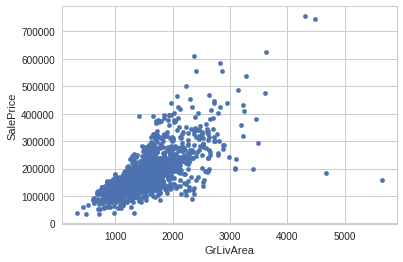

In [20]:
# GrLivArea
data = pd.concat([df_m['SalePrice'], df_m['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice')

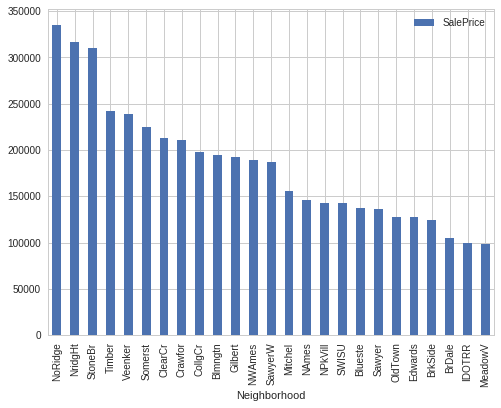

In [21]:
# Mean SalePrice in each Neighborhood
loc_price = df_m[['Neighborhood', 'SalePrice']].groupby('Neighborhood')
loc_price.mean().sort_values('SalePrice', ascending=False).plot(kind='bar', figsize=(8,6))

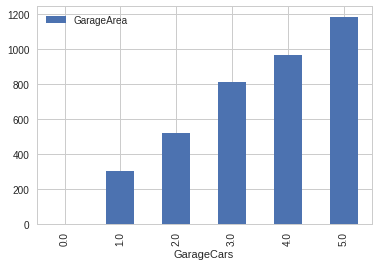

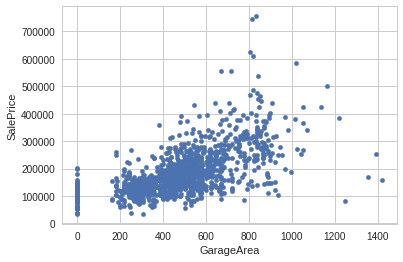

In [22]:
# Garage
df_m[['GarageArea', 'GarageCars']].groupby('GarageCars').mean().plot(kind='bar')

data = pd.concat([df_m['SalePrice'], df_m['GarageArea']], axis=1)
data.plot.scatter(x='GarageArea', y='SalePrice')

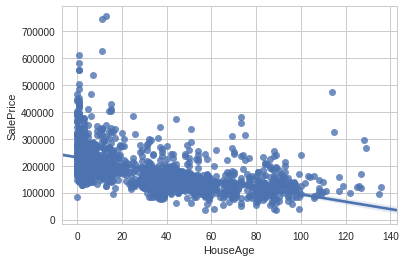

In [23]:
# House Age
df_tmp = df_m.copy()
df_tmp['HouseAge'] = df_tmp['YrSold'] - df_tmp['YearBuilt']
sns.regplot(x='HouseAge', y='SalePrice', data=df_tmp)

In [24]:
# Heating and CentralAir
pd.crosstab(df_m['HeatingQC'], df_m['CentralAir'])

CentralAir,N,Y
HeatingQC,,
1,2,1
2,42,50
3,107,750
4,29,445
5,16,1477


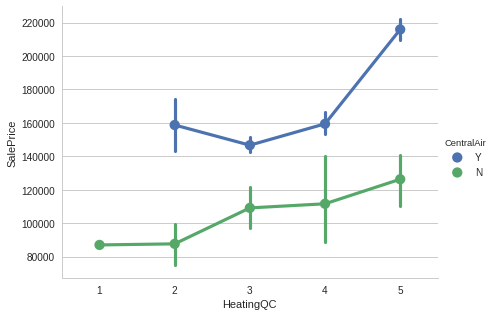

In [25]:
sns.factorplot('HeatingQC', 'SalePrice', hue = 'CentralAir', estimator = np.mean, data = df_m, 
             size = 4.5, aspect = 1.4)

## Normality

In [26]:
def normality(df):
    numeric_cols = [f for f in df if df.dtypes[f] != 'object']
    skew =df[numeric_cols].columns[df[numeric_cols].skew() > 0.1]
    for i in skew.values:
        df[i] = np.log1p(df[i])
    return df

In [27]:
df_normal = normality(df_m)

In [28]:
X_train, y_train, test = preScoreTest(df_normal)
scores = rmsle_cv(xgb, X_train, y_train)
print("RMSE: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 0.1207 (+/- 0.02)


## Create / Discard Features

In [29]:
def drop_low_var(df):
    low_var = [n for n in df_f.columns if df_f[n].value_counts().max()/len(df_f) > 0.97]
    df = df.drop(low_var, axis=1)
    return df

def create_bath(df):
    df['Bath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df = df.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1)
    return df

def create_sq(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    return df

In [30]:
df_f = df_normal.copy()

In [31]:
df_f = drop_low_var(df_f)
df_f = create_bath(df_f)
df_f = create_sq(df_f)

In [32]:
X_train, y_train, test = preScoreTest(df_f)
scores = rmsle_cv(xgb, X_train, y_train)
print("RMSE: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 0.1202 (+/- 0.02)


## Outlier

In [33]:
df_out = df_f.copy()
X_train, y_train, X_test = preScoreTest(df_out)

In [ ]:
import statsmodels.api as sm

regressor = sm.OLS(X_train, y_train).fit()
result = regressor.outlier_test()
outlier = result['bonf(p)']
outlier = outlier[outlier<1e-3].index
print(outlier)

In [34]:
outlier = [462, 523, 632, 968, 1298, 1324]
df_out = df_out.drop(outlier, axis=0)
X_train, y_train, X_test = preScoreTest(df_out, seg = 1454)

In [35]:
scores = rmsle_cv(xgb, X_train, y_train)
print("RMSE: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 0.1082 (+/- 0.02)


### Advanced Imputation
impute 'LotFrontage' after data preprocessing

In [36]:
df_l = df_out.copy()

In [37]:
# Using xgboost to impute missing LotFrontage

null_idx = df_l.loc[df_m['LotFrontage'].isnull()].index

df_lot = df_l.copy()
df_lot = pd.get_dummies(df_lot)
train_lot = df_lot.drop(df_lot.index[[null_idx]])
test_lot = df_lot.loc[null_idx]

test_lot.shape, train_lot.shape

xgb = XGBRegressor(
    colsample_bytree=0.2,
    gamma=0.05,
    learning_rate=0.05, 
    max_depth=5, 
    min_child_weight=3,
    n_estimators=700,
    reg_alpha=0.1,
    reg_lambda=0.005,
    subsample=0.6)


xgb.fit(train_lot.drop(['LotFrontage', 'SalePrice'], axis=1), train_lot['LotFrontage'])
pred_lot = xgb.predict(test_lot.drop(['LotFrontage', 'SalePrice'], axis=1))
df_l.loc[null_idx, 'LotFrontage'] = pred_lot

In [38]:
missing = missing_data(df_l)
print(missing.head(5))

               Missing   Percent
SalePrice         1459  0.500858
TotalSF              0  0.000000
EnclosedPorch        0  0.000000
ExterQual            0  0.000000
Exterior1st          0  0.000000


## Feature Selection

### Random Forest Feature Selection

ref:  
[Selecting good features – Part III: random forests](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)

In [43]:
def rf_imp(df):
    X_train, y_train, X_test = preScoreTest(df_l)
    rfg = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
    rfg.fit(X_train, y_train)
    imp = pd.DataFrame(rfg.feature_importances_, columns=['Importance'], index=X_train.columns).sort_values('Importance', ascending=False)
    return imp

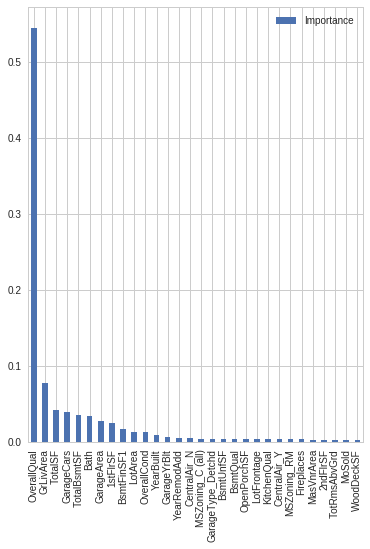

In [44]:
imp = rf_imp(df_f)
imp.head(30).plot(kind = 'bar', figsize=(6, 8))

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def feature_rf(df, imp):
    X_train, y_train, X_test = preScoreTest(df_l, seg = 1454)
    best_rmse = 30000
    n_keeps = int()  
    rmse = []

    xgb_feature = XGBRegressor(learning_rate=0.05,n_estimators=300,max_depth=3,colsample_bytree=0.4)

    for i in range(10,len(imp)+1):
        keep = imp.iloc[0:i].index.values
        rmse_cv = np.sqrt(-cross_val_score(xgb_feature, X_train[keep], y_train, scoring="neg_mean_squared_error", cv = 5))
        rmse += [rmse_cv.mean()]

        if rmse_cv.mean() < best_rmse:
            n_keeps = i
            best_rmse = rmse_cv.mean()   
    
    feature_set = imp.iloc[0:n_keeps].index.values
    
    print('Best RMSE: %s at %s features' % (best_rmse, n_keeps))
    plt.plot(rmse)
    plt.xlabel('# of Features')
    plt.ylabel('RMSE')
    
    return feature_set

Best RMSE: 0.107790867153 at 198 features


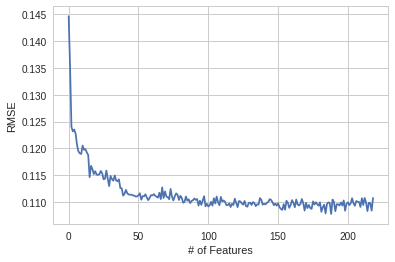

In [46]:
featureSet_rf = feature_rf(df_f, imp)

## Model Selection

In [47]:
X_train, y_train, X_test = preScoreTest(df_l, seg = 1454)

In [48]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import lightgbm

### Hyper Parameter Tunning


In [ ]:
from sklearn.model_selection import GridSearchCV

# XGBoost

kfold = KFold(n_splits=5, shuffle=True, random_state=7)
xgb = XGBRegressor()
parameters = {'n_estimators':[700],
              'learning_rate':[0.05],
              'gamma':[0.05],
              'max_depth':[5],
              'min_child_weight':[3],
              'subsample':[0.6],
              'colsample_bytree':[0.2],
              'reg_lambda':[0.005, 0.01,0.05],
              'reg_alpha':[0.1, 0.3, 0.5,1.0]
             }

grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = kfold)
grid_result_xgb = grid_search_xgb.fit(X_train, y_train)

In [ ]:
grid_result_xgb.best_params_

In [ ]:
# Gradient Boost

gboost = GradientBoostingRegressor()

parameters = {'n_estimators':[700],
              'learning_rate':[0.01,0.03, 0.05], 
              'max_depth':[3], #1~3
              'subsample':[0.6],
              'min_samples_leaf':[2, 5, 10], 
              'min_samples_split':[2],
              'max_features':['log2', 'sqrt', None]
             }
grid_search_gboost = GridSearchCV(estimator=gboost, 
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = kfold)
grid_result_gboost = grid_search_gboost.fit(X_train, y_train)

In [ ]:
grid_result_gboost.best_params_

In [ ]:
# LightGBM
lgb = lightgbm.LGBMRegressor()

parameters = {'n_estimators':[90],
              'learning_rate':[0.08],
              'max_depth':[8],
              'num_leaves':[16],
              'reg_lambda':[0.005, 0.01,0.05],
              'reg_alpha':[0.1, 0.3, 0.5,1.0]
            }
grid_search_lgb = GridSearchCV(estimator=lgb, 
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = kfold)
grid_result_lgb = grid_search_lgb.fit(X_train, y_train)

In [ ]:
grid_result_lgb.best_params_

In [52]:
lasso = Lasso(alpha =0.001, random_state=1)
enet = ElasticNet(alpha=0.001, l1_ratio=.9, random_state=3)
gboost = GradientBoostingRegressor(n_estimators=700, 
                                   learning_rate=0.03,
                                   max_features = 'sqrt',
                                   max_depth=3,
                                   min_samples_leaf=2, 
                                   min_samples_split=2,
                                   subsample=0.6,
                                   loss='huber',
                                   random_state =5)
rfg = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1)
xgb = XGBRegressor(
    colsample_bytree=0.2,
    gamma=0.05,
    learning_rate=0.05, 
    max_depth=5, 
    min_child_weight=3,
    n_estimators=700,
    reg_alpha=0.1,
    reg_lambda=0.005,
    subsample=0.6)
lgb = lightgbm.LGBMRegressor(objective='regression', 
                             learning_rate=0.08, 
                             n_estimators=90,
                             num_leaves=16,
                             max_depth=8,
                             reg_alpha=0.1,
                             reg_lambda=0.01)

krr = KernelRidge(alpha = 7.0)

In [53]:
def scoreTest(X_train, y_train, X_test, models):
    score = {}
    predict = {}
    for m in models:
        name = m.__class__.__name__
        mean = rmsle_cv(m, X_train, y_train).mean()
        score[name] = mean
        
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        
        predict[name] = y_pred
    score = pd.Series(score)
    predict = pd.DataFrame(predict)
    return score, predict
result, predict = scoreTest(X_train, y_train, X_test, models = [lasso ,enet, gboost, xgb, lgb, krr, rfg])
result.sort_values()

/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GradientBoostingRegressor    0.106379
XGBRegressor                 0.108023
ElasticNet                   0.109474
KernelRidge                  0.109639
Lasso                        0.110044
LGBMRegressor                0.117242
RandomForestRegressor        0.132364
dtype: float64

In [54]:
predict.corr()

,ElasticNet,GradientBoostingRegressor,KernelRidge,LGBMRegressor,Lasso,RandomForestRegressor,XGBRegressor
ElasticNet,1.000000,0.987102,0.996328,0.979796,0.999975,0.971465,0.986091
GradientBoostingRegressor,0.987102,1.000000,0.987829,0.990363,0.986857,0.982018,0.995794
KernelRidge,0.996328,0.987829,1.000000,0.979257,0.995984,0.969845,0.986438
LGBMRegressor,0.979796,0.990363,0.979257,1.000000,0.979680,0.990169,0.990955
Lasso,0.999975,0.986857,0.995984,0.979680,1.000000,0.971584,0.985870
RandomForestRegressor,0.971465,0.982018,0.969845,0.990169,0.971584,1.000000,0.982513
XGBRegressor,0.986091,0.995794,0.986438,0.990955,0.985870,0.982513,1.000000


### Ensemble

In [55]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [56]:
gboost2 = GradientBoostingRegressor(n_estimators=700, 
                                   learning_rate=0.03,
                                   max_features = 'sqrt',
                                   max_depth=3,
                                   min_samples_leaf=2, 
                                   min_samples_split=2,
                                   subsample=0.6,
                                   loss='huber',
                                   random_state =1235)
gboost3 = GradientBoostingRegressor(n_estimators=700, 
                                   learning_rate=0.03,
                                   max_features = 'sqrt',
                                   max_depth=3,
                                   min_samples_leaf=2, 
                                   min_samples_split=2,
                                   subsample=0.6,
                                   loss='huber',
                                   random_state =1147)

gboost4 = GradientBoostingRegressor(n_estimators=700, 
                                   learning_rate=0.03,
                                   max_features = 'sqrt',
                                   max_depth=3,
                                   min_samples_leaf=2, 
                                   min_samples_split=2,
                                   subsample=0.6,
                                   loss='huber',
                                   random_state =5487)

In [57]:
averaged_models = AveragingModels(models = (lasso ,enet, gboost
                                            , gboost2, gboost3, gboost4, 
                                            xgb, krr))

score = rmsle_cv(averaged_models, X_train, y_train)
print(" Averaged base models score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


 Averaged base models score: 0.1019 (+/-0.0079)



### Other Feature Sets

In [58]:
# Random Forest

f = imp.iloc[:198].index.values
X_train = X_train[f]
X_test = X_test[f]


result, predict = scoreTest(X_train, y_train, X_test, models = [lasso ,enet, gboost, xgb, lgb, krr, rfg])
result.sort_values()

GradientBoostingRegressor    0.105276
KernelRidge                  0.109322
ElasticNet                   0.109473
Lasso                        0.110045
XGBRegressor                 0.110102
LGBMRegressor                0.117306
RandomForestRegressor        0.132209
dtype: float64

In [62]:
#averaged_models_rf = AveragingModels(models = (xgb1, xgb2, xgb3, gboost, lasso ,enet,krr))
averaged_models_rf = AveragingModels(models = (lasso ,enet, gboost, gboost2, gboost3, gboost4, xgb, krr))
score = rmsle_cv(averaged_models, X_train, y_train)
print(" Averaged base models score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1017 (+/-0.0079)



In [63]:
averaged_models_rf.fit(X_train, y_train)
stacked_pred_rf = np.expm1(averaged_models_rf.predict(X_test))

### Weight SUM!

In [64]:
X_train, y_train, X_test = preScoreTest(df_out, seg = 1454)

averaged_models.fit(X_train, y_train)
stacked_pred = np.expm1(averaged_models.predict(X_test))

xgb.fit(X_train, y_train)
xgb_pred = np.expm1(xgb.predict(X_test))

gboost.fit(X_train, y_train)
gboost_pred = np.expm1(gboost.predict(X_test))

In [65]:
y_pred = (0.1 * gboost_pred + 0.05 * xgb_pred + 0.55 * stacked_pred + 0.3 * stacked_pred_rf)

In [66]:
submission = pd.DataFrame({
    'Id':test_df['Id'],
    'SalePrice':y_pred
})
submission.to_csv('feature_weight_sum', index=False)

## Stacking
AverageModel -> GradientBoostingRegressor

In [67]:
X_train, y_train, X_test = preScoreTest(df_out, seg = 1454)

In [68]:
averaged_models.fit(X_train, y_train)
y_hat_avg = averaged_models.predict(X_train)

In [69]:
gboost5 = GradientBoostingRegressor(n_estimators=700, 
                                   learning_rate=0.03,
                                   max_features = 'sqrt',
                                   max_depth=3,
                                   min_samples_leaf=2, 
                                   min_samples_split=2,
                                   subsample=0.6,
                                   loss='huber',
                                   random_state =1115)
gboost6 = GradientBoostingRegressor(n_estimators=700, 
                                   learning_rate=0.03,
                                   max_features = 'sqrt',
                                   max_depth=3,
                                   min_samples_leaf=2, 
                                   min_samples_split=2,
                                   subsample=0.6,
                                   loss='huber',
                                   random_state =2145)
gboost7 = GradientBoostingRegressor(n_estimators=700, 
                                   learning_rate=0.03,
                                   max_features = 'sqrt',
                                   max_depth=3,
                                   min_samples_leaf=2, 
                                   min_samples_split=2,
                                   subsample=0.6,
                                   loss='huber',
                                   random_state =9897)

In [70]:
avg_gboost = AveragingModels(models = (gboost5, gboost6, gboost7))

In [71]:
scores = rmsle_cv(avg_gboost, X_train, y_hat_avg)
print("RMSE: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSE: 0.0407 (+/- 0.01)


In [72]:
avg_gboost.fit(X_train, y_hat_avg)
two_stacked_y_pred = np.expm1(avg_gboost.predict(X_test))

In [73]:
two_stacked_y_pred

array([ 123184.01052349,  156594.83257214,  186009.96969896, ...,
        164349.80293235,  125381.17029056,  227027.10137618])

In [74]:
submission = pd.DataFrame({
    'Id':test_df['Id'],
    'SalePrice':two_stacked_y_pred
})
submission.to_csv('2_stack_pred', index=False)

## Interpretation
ref:   
[Selecting Good Featuers](http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/)  
[Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models)

In [75]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 7, 10, 15, 30, 50, 75]
cv_ridge = [rmsle_cv(Ridge(alpha = alpha), X_train, y_train).mean() 
            for alpha in alphas]

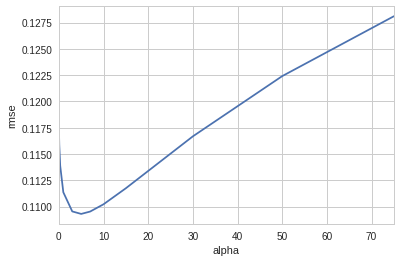

In [76]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")

min at alpha=7 

In [77]:
model_ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

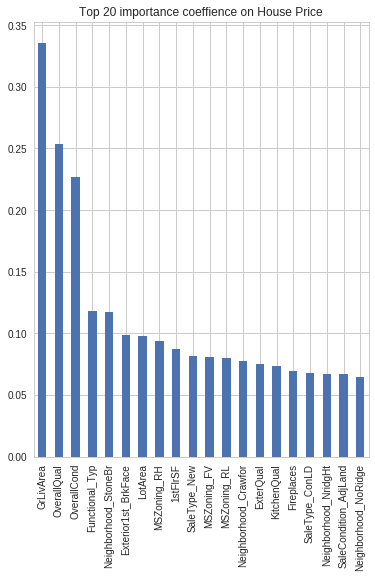

In [78]:
coef = pd.Series(model_ridge.coef_, index=X_train.columns)
imp_coef = coef.sort_values(ascending=False).head(20)

plt.title('Top 20 importance coeffience on House Price')
imp_coef.plot(kind = 'bar', figsize=(6, 8))
